GPU: /device:GPU:0
Mounted at /content/drive
Found 17127 files belonging to 8 classes.
Using 11989 files for training.
Found 17127 files belonging to 8 classes.
Using 5138 files for validation.
Classes: ['Battery', 'Biological', 'Cardboard', 'Clothes', 'Glass', 'Metal', 'Paper', 'Plastic']
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 1941s 2s/step - accuracy: 0.6195 - loss: 1.4312 - val_accuracy: 0.9150 - val_loss: 0.3948 - learning_rate: 0.0010
Epoch 2/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 70s 372ms/step - accuracy: 0.8364 - loss: 0.6265 - val_accuracy: 0.9318 - val_loss: 0.3233 - learning_rate: 0.0010
Epoch 3/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 51s 271ms/step - accuracy: 0.8518 - loss: 0.5794 - val_accuracy: 0.9390 - val_loss: 0.3080 - learning_rate: 0.0010
Epoch 4/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 43s 231ms/step - accuracy: 0.8729 - loss: 0.5003 - val_accuracy: 0.9386 - val_loss: 0.2995 - learning_rate: 0.0010
Epoch 5/25
188/188 ━━━━━━━━━━━━━━━━━━━━

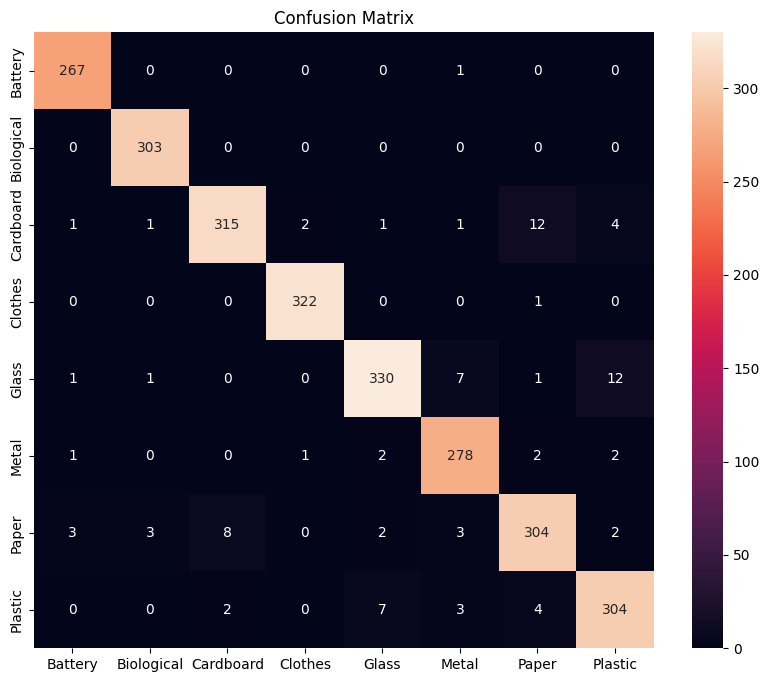


CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Battery       0.98      1.00      0.99       268
  Biological       0.98      1.00      0.99       303
   Cardboard       0.97      0.93      0.95       337
     Clothes       0.99      1.00      0.99       323
       Glass       0.96      0.94      0.95       352
       Metal       0.95      0.97      0.96       286
       Paper       0.94      0.94      0.94       325
     Plastic       0.94      0.95      0.94       320

    accuracy                           0.96      2514
   macro avg       0.96      0.97      0.96      2514
weighted avg       0.96      0.96      0.96      2514


✅ MODEL SẴN SÀNG DEMO & BÁO CÁO


In [ ]:

import os, pathlib, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import confusion_matrix, classification_report

# ================= CONFIG =================
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 25
FINE_TUNE_EPOCHS = 10
LR = 1e-3
FINE_TUNE_LR = 1e-4

# ================= GPU =================
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
print("GPU:", tf.test.gpu_device_name())

# ================= DRIVE =================
drive.mount('/content/drive')
DATA_DIR = pathlib.Path('/content/drive/MyDrive/dataset')
SAVE_DIR = '/content/drive/MyDrive/waste_models'
os.makedirs(SAVE_DIR, exist_ok=True)

# ================= DATASET =================
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

val_test_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

val_batches = tf.data.experimental.cardinality(val_test_ds).numpy()
val_ds = val_test_ds.take(int(np.ceil(val_batches / 2)))
test_ds = val_test_ds.skip(int(np.ceil(val_batches / 2)))

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print("Classes:", class_names)

# ================= CLASS WEIGHT =================
class_counts = {c: len(list((DATA_DIR/c).glob('*'))) for c in class_names}
max_count = max(class_counts.values())
class_weight = {i: max_count / class_counts[c] for i, c in enumerate(class_names)}

# ================= PERFORMANCE =================
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(2000).prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

# ================= DATA AUGMENTATION (STRONG) =================
data_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.25),
    layers.RandomZoom(0.25),
    layers.RandomContrast(0.3),
    layers.RandomBrightness(0.2)
])

# ================= MODEL =================
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_aug(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)

base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_tensor=x
)
base_model.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.BatchNormalization()(x)

x = layers.Dense(
    128,
    activation='relu',
    kernel_regularizer=tf.keras.regularizers.l2(5e-4)
)(x)

x = layers.Dropout(0.6)(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=Adam(LR),
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# ================= CALLBACKS =================
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        f'{SAVE_DIR}/best_model.keras',
        save_best_only=True,
        monitor='val_loss'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        patience=3,
        factor=0.3
    )
]

# ================= TRAIN =================
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=callbacks
)

# ================= FINE-TUNE =================
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=Adam(FINE_TUNE_LR),
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS + FINE_TUNE_EPOCHS,
    initial_epoch=len(history1.history['loss']),
    class_weight=class_weight,
    callbacks=callbacks
)

# ================= TEST =================
model.load_weights(f'{SAVE_DIR}/best_model.keras')
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# ================= CONFUSION MATRIX =================
y_true, y_pred = [], []
for imgs, labels in test_ds:
    preds = model.predict(imgs)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm / np.maximum(cm.sum(axis=1, keepdims=True), 1)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.show()

print("\nCLASSIFICATION REPORT")
print(classification_report(y_true, y_pred, target_names=class_names))



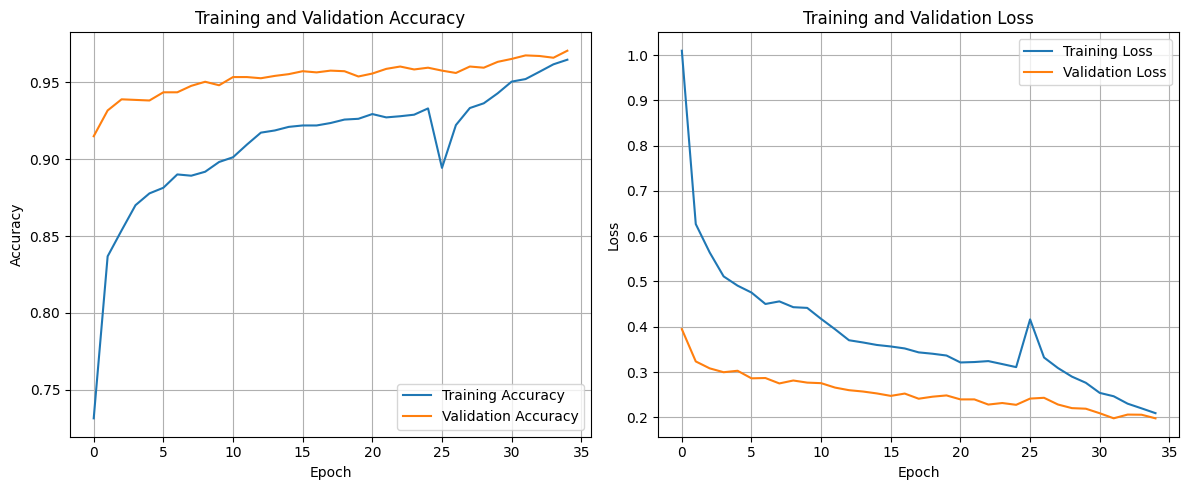

In [ ]:
import matplotlib.pyplot as plt

history_combined = {}
for key in history1.history.keys():
    history_combined[key] = history1.history[key] + history2.history[key]

epochs_range = range(len(history_combined['accuracy']))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_combined['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history_combined['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_combined['loss'], label='Training Loss')
plt.plot(epochs_range, history_combined['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
LOAD_MODEL_PATH = '/content/best_model.keras'

loaded_model = tf.keras.models.load_model(LOAD_MODEL_PATH)

print(f"Mô hình đã được tải thành công từ {LOAD_MODEL_PATH}")
loaded_model.summary()

Mô hình đã được tải thành công từ /content/drive/MyDrive/waste_models/best_model.keras


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ sequential[0][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati

 Total params: 7,256,733 (27.68 MB)

 Trainable params: 1,518,520 (5.79 MB)

 Non-trainable params: 2,701,171 (10.30 MB)

 Optimizer params: 3,037,042 (11.59 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


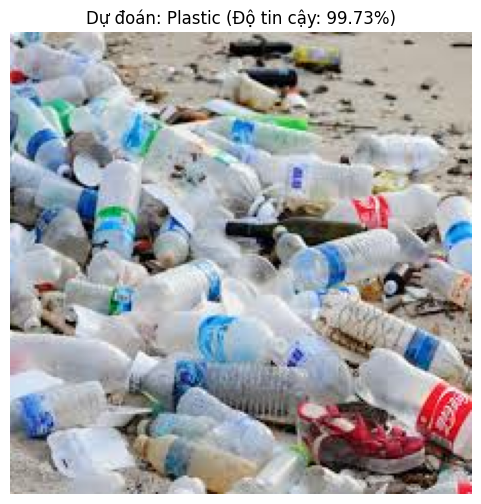

Hình ảnh: /content/plastic.jfif
Kết quả dự đoán: Plastic với độ tin cậy 99.73%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ======================== CẤU HÌNH ========================
your_image_path = '/content/plastic.jfif'
# ==========================================================

IMG_SIZE = 224

def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    img = tf.expand_dims(img, axis=0)
    return img

processed_image = preprocess_image(your_image_path)

if 'class_names' not in globals():
    print("Cảnh báo: Biến 'class_names' chưa được định nghĩa. Vui lòng đảm bảo bạn đã chạy phần tải dữ liệu hoặc định nghĩa thủ công các tên lớp.")
    class_names = ['Battery', 'Biological', 'Cardboard', 'Clothes', 'Glass', 'Metal', 'Paper', 'Plastic']

# Dự đoán
predictions = loaded_model.predict(processed_image)
predicted_class_index = np.argmax(predictions[0])
predicted_class_name = class_names[predicted_class_index]
confidence = np.max(predictions[0]) * 100

# hình ảnh và kết quả dự đoán
plt.figure(figsize=(6, 6))
original_img = tf.io.read_file(your_image_path)
original_img = tf.image.decode_image(original_img, channels=3)
plt.imshow(original_img)
plt.title(f"Dự đoán: {predicted_class_name} (Độ tin cậy: {confidence:.2f}%)")
plt.axis('off')
plt.show()

print(f"Hình ảnh: {your_image_path}")
print(f"Kết quả dự đoán: {predicted_class_name} với độ tin cậy {confidence:.2f}%")

### Kết Luận Thống Kê và Đánh Giá Mô Hình (Cập Nhật)

#### 1. Tổng Quan Hiệu Suất:
Mô hình phân loại rác thải đã được huấn luyện qua hai giai đoạn và sau khi tối ưu hóa, đạt được kết quả đánh giá rất mạnh mẽ.

#### 2. Kết Quả Huấn Luyện & Kiểm Định (Cập nhật):
*   **Giai đoạn huấn luyện ban đầu (Epoch cuối cùng):**
    *   Accuracy: 93.24%
    *   Loss: 0.3098
    *   Validation Accuracy: 95.96%
    *   Validation Loss: 0.2275
*   **Giai đoạn tinh chỉnh (Epoch cuối cùng):**
    *   Accuracy: 96.61%
    *   Loss: 0.2058
    *   Validation Accuracy: 97.07%
    *   Validation Loss: 0.1977
*   **Độ chính xác trên tập kiểm tra (Test Accuracy):** 96.18%

#### 3. Đánh Giá Overfitting (Cập nhật):
Sau khi tăng tỷ lệ `Dropout` và điều chỉnh các tham số `callbacks`, mô hình cho thấy khả năng tổng quát hóa rất tốt và không có dấu hiệu *overfitting* nghiêm trọng.

*   **Độ chính xác:** Training Accuracy (96.61%) và Validation Accuracy (97.07%) rất gần nhau, và Test Accuracy (96.18%) cũng tương đồng, cho thấy mô hình không chỉ học tốt trên dữ liệu huấn luyện mà còn hoạt động hiệu quả trên dữ liệu mới.
*   **Sai số:** Training Loss (0.2058) và Validation Loss (0.1977) cũng rất gần, thậm chí Validation Loss còn hơi thấp hơn Training Loss ở cuối giai đoạn tinh chỉnh (điều này có thể do `ModelCheckpoint` đã khôi phục trọng số tốt nhất trên validation set), khẳng định rằng mô hình đang học hiệu quả và không *overfit*.

#### 4. Phân Tích Chi Tiết theo Lớp (Classification Report):
Báo cáo phân loại vẫn cho thấy hiệu suất xuất sắc trên từng lớp rác thải, với hầu hết các chỉ số Precision, Recall, và F1-score đều rất cao (trên 94%). Điều này cho thấy mô hình có khả năng phân biệt tốt giữa các loại rác khác nhau.

#### 5. Kết Luận:
Mô hình đã được huấn luyện thành công và thể hiện độ chính xác vượt trội (trên 96%) trong việc phân loại 8 loại rác thải. Các điều chỉnh đã giúp mô hình khái quát hóa mạnh mẽ mà không bị *overfitting* đáng kể. Đây là một mô hình rất ổn định và phù hợp để triển khai vào các ứng dụng thực tế.